 1. Imports and Configurations

In [10]:
#Imports all necessary libraries for data handling, model building, and training.
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Configuration
DATA_PATH = 'data'                  # Path to the dataset directory
IMG_SIZE = (64, 64)                 # Target image size for resizing
BATCH_SIZE = 32                     # Number of samples per training batch
NUM_EPOCHS = 30                     # Total number of training epochs
LATENT_DIM_1 = 64                   # Latent dimension size for z1
LATENT_DIM_2 = 32                   # Latent dimension size for z2 (deeper hierarchy)


 2. Data Generator (Unsupervised)

In [16]:
# Data generator without labels (unsupervised)
 #Normalizes image pixels to [0, 1] and splits dataset into training/validation.

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [18]:
train_generator = datagen.flow_from_directory(
    DATA_PATH,                      # Directory containing images
    target_size=IMG_SIZE,           # Resize all images to IMG_SIZE
    batch_size=BATCH_SIZE,          # Batch size
    class_mode=None,                # No labels since it's unsupervised
    subset='training',              # Use 80% of data for training
    shuffle=True,                   # Shuffle data for training
    seed=42                         # Seed for reproducibility
)


val_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset='validation',            # Use 20% of data for validation
    shuffle=False                   # No need to shuffle validation data
)


Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


🔹 3. Sampling Layer for Reparameterization Trick

In [19]:
#Allows gradients to pass through stochastic nodes by sampling from a Gaussian.

# Sampling layer for reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(tf.shape(mean))  # Random noise ~ N(0,1)
        return mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization


 4. Encoder Network

In [20]:
def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)                         # Input image
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)  # Downsample to 32x32
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)       # Downsample to 16x16
    x = layers.Flatten()(x)                                          # Flatten to vector
    x = layers.Dense(128, activation='relu')(x)                      # Dense hidden layer

    # First latent layer (z1)
    z1_mean = layers.Dense(LATENT_DIM_1)(x)
    z1_log_var = layers.Dense(LATENT_DIM_1)(x)
    z1 = Sampling()([z1_mean, z1_log_var])

    # Second latent layer (z2), conditioned on z1
    z2_mean = layers.Dense(LATENT_DIM_2)(z1)
    z2_log_var = layers.Dense(LATENT_DIM_2)(z1)
    z2 = Sampling()([z2_mean, z2_log_var])

    return models.Model(inputs, [z1_mean, z1_log_var, z1, z2_mean, z2_log_var, z2], name="Encoder")

#Maps input image → z1 → z2 using convolution + dense layers.

5. Decoder Network

In [21]:
#Reconstructs image from z2 latent representation using transposed convolutions.

def build_decoder(output_shape):
    z2_input = layers.Input(shape=(LATENT_DIM_2,))                   # Input latent vector z2
    x = layers.Dense(8*8*64, activation='relu')(z2_input)            # Project to shape suitable for reshaping
    x = layers.Reshape((8, 8, 64))(x)                                # Reshape into image block

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 16x16
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # 32x32
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)  # 64x64
    x = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)           # Final RGB image
    return models.Model(z2_input, x, name="Decoder")


6. HVAE Model Class (Training & Losses)

In [33]:
class HVAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(HVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super(HVAE, self).compile()
        self.optimizer = optimizer

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker
        ]
#Training Step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z1_mean, z1_log_var, z1, z2_mean, z2_log_var, z2 = self.encoder(data)
            reconstruction = self.decoder(z2)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
            kl_loss_1 = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z1_log_var - tf.square(z1_mean) - tf.exp(z1_log_var), axis=1))
            kl_loss_2 = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z2_log_var - tf.square(z2_mean) - tf.exp(z2_log_var), axis=1))
            total_loss = recon_loss + kl_loss_1 + kl_loss_2

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss_1 + kl_loss_2)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }
#Validation Step

    def test_step(self, data):
        z1_mean, z1_log_var, z1, z2_mean, z2_log_var, z2 = self.encoder(data)
        reconstruction = self.decoder(z2)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
        kl_loss_1 = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z1_log_var - tf.square(z1_mean) - tf.exp(z1_log_var), axis=1))
        kl_loss_2 = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z2_log_var - tf.square(z2_mean) - tf.exp(z2_log_var), axis=1))
        total_loss = recon_loss + kl_loss_1 + kl_loss_2

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss_1 + kl_loss_2)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }
#Build and Train the Model

# Build and compile model
input_shape = IMG_SIZE + (3,)             # (64, 64, 3)
encoder = build_encoder(input_shape)      # Instantiate encoder
decoder = build_decoder(input_shape)      # Instantiate decoder
model = HVAE(encoder, decoder)            # Create full HVAE model
model.compile(optimizer=optimizers.Adam())# Compile with Adam optimizer

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)



Epoch 1/30
52/52 [==============================] - 12s 174ms/step - loss: 541.5773 - reconstruction_loss: 516.6884 - kl_loss: 24.8890 - val_loss: 548.1063 - val_reconstruction_loss: 526.2956 - val_kl_loss: 21.8107
Epoch 2/30
52/52 [==============================] - 8s 153ms/step - loss: 485.0198 - reconstruction_loss: 457.0467 - kl_loss: 27.9732 - val_loss: 490.9354 - val_reconstruction_loss: 463.6928 - val_kl_loss: 27.2425
Epoch 3/30
52/52 [==============================] - 9s 165ms/step - loss: 458.9152 - reconstruction_loss: 432.2359 - kl_loss: 26.6793 - val_loss: 478.7020 - val_reconstruction_loss: 452.4886 - val_kl_loss: 26.2134
Epoch 4/30
52/52 [==============================] - 9s 173ms/step - loss: 446.8124 - reconstruction_loss: 421.5319 - kl_loss: 25.2807 - val_loss: 471.8487 - val_reconstruction_loss: 448.1176 - val_kl_loss: 23.7310
Epoch 5/30
52/52 [==============================] - 9s 164ms/step - loss: 444.6735 - reconstruction_loss: 420.1611 - kl_loss: 24.5123 - val_los

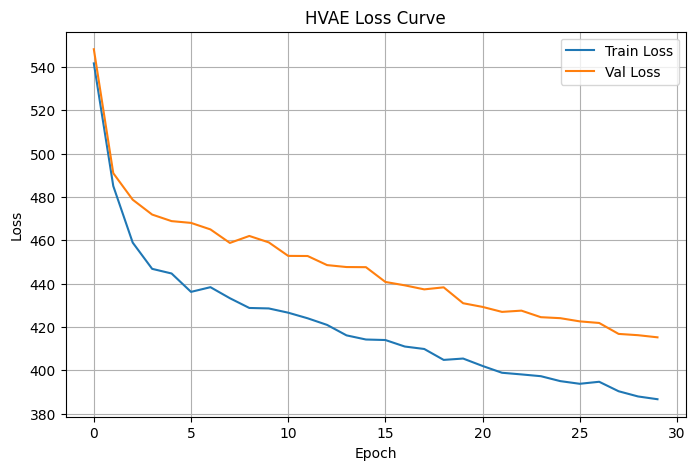

In [34]:
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('HVAE Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
